In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
from google.colab import files

# CSV 파일 업로드
uploaded = files.upload()

# 업로드된 파일 이름 가져오기
filename = list(uploaded.keys())[0]

print(f"업로드된 파일: {filename}")


Saving sample_submission.csv to sample_submission.csv
Saving test.csv to test.csv
Saving train.csv to train.csv
업로드된 파일: sample_submission.csv


In [3]:
# 학습/평가 데이터 로드
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# '[.]'을 '.'으로 복구

train_df['URL'] = train_df['URL'].str.replace(r'\[\.\]', '.', regex=True)
test_df['URL'] = test_df['URL'].str.replace(r'\[\.\]', '.', regex=True)

In [5]:
from urllib.parse import urlparse
from collections import Counter
import re

data = {
    'url': train_df['URL'],
    'label': train_df['label']
}

# DataFrame으로 변환
df = pd.DataFrame(data)

# 정상 URL만 필터링
benign_urls = df[df['label'] == 0]['url']


def extract_tld(url):
    try:
        # URL에서 도메인 부분만 추출
        domain = url.split('/')[0].split(':')[0]  # 포트 번호나 경로를 제외하고 도메인만 추출

        # 도메인 부분에서 마지막 '.' 뒤의 부분을 TLD로 간주
        domain_parts = domain.split('.')

        # 도메인 구조가 이상해도 마지막 부분을 TLD로 추출
        if len(domain_parts) > 1:
            tld = domain_parts[-1]
            # TLD가 영문으로 끝나는지 확인 (IP나 숫자 제외)
            if re.match(r'^[a-zA-Z]+$', tld):
                return tld
        return None  # TLD가 없는 경우는 None 반환
    except Exception as e:
        print(f"❌ URL 처리 중 오류 발생: {url} → {e}")
        return None


# 정상 URL에서 TLD 추출
tlds = [extract_tld(url) for url in benign_urls]

# None 값 제거 (TLD 추출이 실패한 경우)
tlds = [tld for tld in tlds if tld is not None]

# TLD 빈도수 계산
tld_counts = Counter(tlds)
# 빈도순 정렬
sorted_tlds = sorted(tld_counts.items(), key=lambda x: x[1], reverse=True)

# 자주 등장하는 TLD 출력
print("자주 등장하는 TLD 정상 목록:")
for tld, count in sorted_tlds:
    print(f"{tld}: {count}번")

자주 등장하는 TLD 정상 목록:
com: 2554708번
org: 433445번
de: 293486번
net: 238724번
uk: 228241번
ru: 160485번
edu: 94074번
it: 92858번
jp: 87962번
fr: 68443번
nl: 65253번
au: 63616번
ca: 59844번
pl: 59018번
ch: 37308번
info: 36644번
cn: 34781번
br: 31113번
tr: 28508번
dk: 27019번
ua: 25464번
us: 25011번
es: 24341번
in: 24289번
cz: 24131번
at: 22472번
be: 21080번
nz: 19517번
gov: 19330번
eu: 19298번
se: 18777번
io: 17081번
co: 15397번
ro: 14832번
hu: 13713번
ir: 13240번
gr: 13009번
biz: 12975번
kr: 12675번
xyz: 11910번
tw: 11813번
top: 11510번
za: 11245번
ar: 10364번
no: 10274번
tv: 8851번
fi: 8805번
ie: 8717번
me: 8286번
mx: 8156번
sk: 7694번
il: 7436번
cc: 6545번
id: 6044번
by: 6033번
vn: 5876번
pt: 5811번
cl: 5773번
online: 5052번
hk: 4856번
lt: 4821번
site: 4363번
club: 4116번
pro: 4010번
my: 3884번
app: 3851번
sg: 3790번
hr: 3648번
su: 3526번
ee: 3232번
cf: 3156번
kz: 2989번
lv: 2827번
win: 2744번
nu: 2730번
th: 2709번
bg: 2686번
rs: 2457번
pk: 2436번
cat: 2392번
ga: 2289번
quest: 2272번
az: 2176번
ph: 2152번
si: 2132번
am: 2097번
shop: 2063번
to: 1896번
uz: 1850번
pe: 1794번
mi

In [6]:

# 악성 URL만 필터링
malicious_urls = df[df['label'] == 1]['url']


def extract_tld(url):
    try:
        # URL에서 도메인 부분만 추출
        domain = url.split('/')[0].split(':')[0]  # 포트 번호나 경로를 제외하고 도메인만 추출

        # 도메인 부분에서 마지막 '.' 뒤의 부분을 TLD로 간주
        domain_parts = domain.split('.')

        # 도메인 구조가 이상해도 마지막 부분을 TLD로 추출
        if len(domain_parts) > 1:
            tld = domain_parts[-1]
            # TLD가 영문으로 끝나는지 확인 (IP나 숫자 제외)
            if re.match(r'^[a-zA-Z]+$', tld):
                return tld
        return None  # TLD가 없는 경우는 None 반환
    except Exception as e:
        print(f"❌ URL 처리 중 오류 발생: {url} → {e}")
        return None


# 악성 URL에서 TLD 추출
tlds = [extract_tld(url) for url in malicious_urls]

# None 값 제거 (TLD 추출이 실패한 경우)
tlds = [tld for tld in tlds if tld is not None]

# TLD 빈도수 계산
tld_counts = Counter(tlds)
# 빈도순 정렬
sorted_tlds = sorted(tld_counts.items(), key=lambda x: x[1], reverse=True)

# 자주 등장하는 TLD 출력
print("자주 등장하는 TLD 악성 목록:")
for tld, count in sorted_tlds:
    print(f"{tld}: {count}번")

자주 등장하는 TLD 악성 목록:
com: 671529번
org: 83698번
net: 54337번
top: 44740번
ru: 42227번
app: 35229번
xyz: 33188번
cn: 32140번
co: 28519번
br: 22201번
tk: 19427번
in: 16110번
info: 15708번
club: 14750번
ml: 13806번
uk: 13027번
me: 12552번
ga: 12042번
io: 11561번
de: 10697번
icu: 10420번
cf: 9967번
id: 9859번
shop: 9383번
au: 8897번
ly: 8711번
site: 8073번
gq: 8007번
live: 7963번
pl: 7900번
link: 7199번
fr: 6959번
us: 6807번
ca: 6581번
cc: 6545번
mx: 6483번
cl: 6433번
dev: 6156번
page: 6143번
online: 6103번
it: 6069번
ci: 5747번
es: 5661번
ir: 4999번
vu: 4772번
eu: 4719번
za: 4591번
cloud: 4380번
biz: 4035번
buzz: 4029번
ro: 3620번
jp: 3461번
be: 3359번
ua: 3316번
nl: 3123번
ar: 2714번
ch: 2680번
ke: 2624번
pw: 2543번
pk: 2474번
hu: 2404번
vn: 2383번
gr: 2306번
tr: 2109번
ae: 1868번
do: 1787번
bg: 1760번
gd: 1696번
pro: 1664번
tech: 1644번
cyou: 1604번
asia: 1572번
my: 1544번
dk: 1497번
kz: 1453번
ma: 1438번
cz: 1423번
ng: 1407번
space: 1406번
pe: 1397번
tv: 1360번
kr: 1357번
uz: 1313번
work: 1307번
website: 1299번
pt: 1272번
fun: 1220번
re: 1148번
lt: 1145번
to: 1123번
th: 1036번

In [7]:
# 악성 URL에서 TLD 추출
malicious_tlds = [extract_tld(url) for url in malicious_urls]
benign_tlds = [extract_tld(url) for url in benign_urls]

# None 값 제거 (TLD 추출이 실패한 경우)
malicious_tlds = [tld for tld in malicious_tlds if tld is not None]
benign_tlds = [tld for tld in benign_tlds if tld is not None]

#악성 URL과 정상 URL에서 TLD 빈도수 계산
malicious_tld_counts = Counter(malicious_tlds)
benign_tld_counts = Counter(benign_tlds)

# 정상 URL에서의 TLD 카운트와 악성 URL에서의 TLD 카운트 비교
threshold = 0.55  # 악성 URL 카운트가 정상 URL 카운트의 0.7배보다 클 경우

high_prob_malicious_tlds = []
for tld, malicious_count in malicious_tld_counts.items():
    benign_count = benign_tld_counts.get(tld, 0)  # 정상 URL에서 해당 TLD 카운트 가져오기, 없으면 0
    if benign_count == 0 or malicious_count > benign_count * threshold:
        high_prob_malicious_tlds.append((tld, malicious_count))  # TLD와 악성 URL 카운트를 튜플로 저장

# 카운트를 기준으로 내림차순 정렬
high_prob_malicious_tlds.sort(key=lambda x: x[1], reverse=True)

# 결과 출력
if high_prob_malicious_tlds:
    print("악성 URL에서 특징이 강한 최상위 도메인 (카운트 높은 순):")
    for item in high_prob_malicious_tlds:  # 튜플 형식으로 출력
        tld, count = item  # 튜플을 분리하여 TLD와 카운트 저장
        print(f"{tld}: {count}")


악성 URL에서 특징이 강한 최상위 도메인 (카운트 높은 순):
top: 44740
app: 35229
xyz: 33188
cn: 32140
co: 28519
br: 22201
tk: 19427
in: 16110
club: 14750
ml: 13806
me: 12552
ga: 12042
io: 11561
icu: 10420
cf: 9967
id: 9859
shop: 9383
ly: 8711
site: 8073
gq: 8007
live: 7963
link: 7199
cc: 6545
mx: 6483
cl: 6433
dev: 6156
page: 6143
online: 6103
ci: 5747
vu: 4772
cloud: 4380
buzz: 4029
ke: 2624
pw: 2543
pk: 2474
ae: 1868
do: 1787
bg: 1760
gd: 1696
tech: 1644
cyou: 1604
asia: 1572
ma: 1438
ng: 1407
space: 1406
pe: 1397
uz: 1313
work: 1307
website: 1299
fun: 1220
re: 1148
to: 1123
monster: 1004
click: 994
bar: 916
vip: 874
tokyo: 817
host: 816
one: 797
gl: 789
np: 774
support: 770
ve: 747
gy: 746
casa: 739
bd: 727
ge: 678
life: 670
ps: 646
store: 646
ba: 625
digital: 610
im: 592
best: 521
services: 469
vc: 466
world: 432
sh: 432
tz: 428
mw: 397
mn: 387
mk: 380
army: 359
ms: 358
art: 357
gle: 345
finance: 344
ltd: 340
email: 319
rest: 315
ink: 308
py: 306
nf: 300
cx: 297
bond: 280
ug: 280
ht: 274
tf: 263
cfd: 255

In [8]:
# 이상한 TLD를 블랙리스트로 설정
blacklist_tlds = [
    'top', 'app', 'xyz', 'cn', 'co', 'br', 'tk', 'in', 'club', 'ml',
    'me', 'ga', 'io', 'icu', 'cf', 'id', 'shop', 'ly', 'site', 'gq',
    'live', 'link', 'cc', 'mx', 'cl', 'dev', 'page', 'online', 'ci',
    'vu', 'cloud', 'buzz', 'ke', 'pw', 'pk', 'ae', 'do', 'bg', 'gd',
    'tech', 'cyou', 'asia', 'ma', 'ng', 'space', 'pe', 'uz', 'work',
    'website', 'fun', 're', 'to', 'monster', 'click', 'bar', 'vip',
    'tokyo', 'host', 'one', 'gl', 'np', 'support', 've', 'gy', 'casa',
    'bd', 'ge', 'life', 'ps', 'store', 'ba', 'digital', 'im', 'best',
    'services', 'vc', 'world', 'sh', 'tz', 'mw', 'mn', 'mk', 'army',
    'ms', 'art', 'gle', 'finance', 'ltd', 'email', 'rest', 'ink', 'py',
    'nf', 'cx', 'bond', 'ug', 'ht', 'tf', 'cfd', 'zw', 'mu', 'cam',
    'sv', 'stream', 'bio', 'review', 'business', 'help', 'sbs', 'agency',
    'rw', 'bo', 'cm', 'ac', 'mz', 'tc', 'center', 'qa', 'mp', 'group',
    'so', 'sd', 'ovh', 'goog', 'vg', 'af', 'gift', 'date', 'gh', 'navy',
    'sn', 'fit', 'africa', 'uno', 'cool', 'exchange', 'pn', 'pictures',
    'academy', 'pf', 'tg', 'cv', 'gs', 'gp', 'lc', 'pm', 'mom', 'mg',
    'surf', 'lat', 'house', 'ooo', 'zm', 'tel', 'gm', 'hosting', 'market',
    'sb', 'fund', 'pharmacy', 'black', 'loan', 'tax', 'ls', 'place',
    'homes', 'claims', 'financial', 'promo', 'delivery', 'direct',
    'domains', 'kim', 'limited', 'COM', 'wf', 'legal', 'pet', 'management',
    'recipes', 'contact', 'yoga', 'wien', 'band', 'coupons', 'yt', 'gifts',
    'clinic', 'credit', 'krd', 'estate', 'hm', 'llc', 'srl', 'limo',
    'healthcare', 'accountant', 'futbol', 'ltda', 'XYZ', 'rentals', 'nr',
    'sydney', 'miami', 'properties', 'yachts', 'enterprises', 'accountants',
    'vacations', 'melbourne', 'apartments', 'mortgage', 'industries', 'gf',
    'construction', 'makeup', 'auction', 'associates', 'jewelry', 'creditcard',
    'salon', 'NET', 'holdings', 'lawyer', 'reise', 'ceo', 'realestate',
    'gripe', 'boston', 'realty', 'CO', 'contractors', 'ICU', 'equipment',
    'tp', 'luxe', 'surgery', 'RU', 'MOBI', 'villas', 'republican', 'ORG',
    'LIFE', 'WEBSITE', 'CC', 'PRESS', 'Net', 'DIGITAL', 'lundbeck', 'TK',
    'SPACE', 'ZA', 'US', 'moi', 'cruises', 'Com', 'ONLINE', 'Space', 'Us',
    'comht', 'padariamorgadopt', 'an', 'node'
]

# 악성 URL 검출 함수
def detect_malicious_url(url):
    tld = extract_tld(url)
    if tld in blacklist_tlds:
        return True  # 블랙리스트에 포함된 TLD인 경우 악성 URL로 판단
    return False  # 그렇지 않으면 악성 URL이 아님

# 모든 URL에서 악성 URL 검출
df['is_malicious'] = df['url'].apply(lambda x: detect_malicious_url(x))

# 악성 URL이 포함된 데이터 출력
malicious_df = df[df['is_malicious'] == True]
print(f"악성 URL 개수: {len(malicious_df)}")
print(malicious_df[['url', 'label', 'is_malicious']])

악성 URL 개수: 769169
                                                      url  label  is_malicious
5                                      93fm.radio.br/file      1          True
6        ps.com.vu/wp-config/wp-incluides/soft/ursnbxmmvd      1          True
8                                          microsoft.ltda      0          True
13                                        adonis.holdings      0          True
14                                        jalawave.net.id      1          True
...                                                   ...    ...           ...
6995020                                       tlws.gov.cn      0          True
6995023              verifikasi-akun-login56.cf/index.php      1          True
6995028                      cheapviagra50tablets.monster      0          True
6995032             marketingservices.direct/Folder/Inbox      1          True
6995044                                         rthe.top/      1          True

[769169 rows x 3 columns]


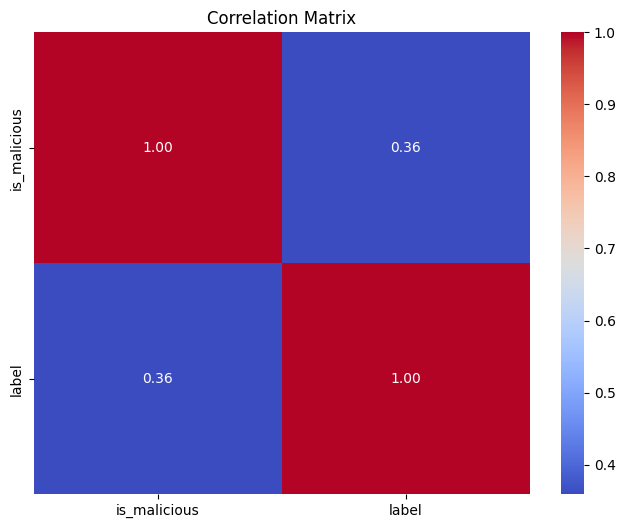

In [9]:
# 'is_malicious' 컬럼 추가: 블랙리스트 TLD를 기반으로 악성 URL로 판단된 결과
df['is_malicious'] = df['url'].apply(lambda x: detect_malicious_url(x))

# 상관계수 계산
correlation_matrix = df[[ 'is_malicious', 'label']].corr()

# 히트맵 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [10]:


# IPv4 정규식 (각 숫자가 0~255 범위 내에 존재)
ipv4_pattern = r"(?:(?:25[0-5]|2[0-4][0-9]|1?[0-9][0-9]?)\.){3}(?:25[0-5]|2[0-4][0-9]|1?[0-9][0-9]?)"

# IPv6 정규식 (간단한 형식, 자세한 검사는 필요할 수 있음)
ipv6_pattern = r"([0-9a-fA-F]{1,4}:){1,7}[0-9a-fA-F]{1,4}"

# URL 내 IP 포함 여부 확인 함수
def contains_ip(url):
    if re.search(ipv4_pattern, url) or re.search(ipv6_pattern, url):
        return True  # IP 포함 시 유효한 URL
    return False  # IP 미포함 시 유효하지 않음



# IP 포함 여부 확인 후 새로운 컬럼 추가
df['contains_ip'] = df['url'].apply(contains_ip)

# IP 없는 URL을 "악성 URL"로 간주
df['is_malicious_by_ip'] = ~df['contains_ip']

# 악성 URL 출력 (IP 없는 경우)
malicious_df = df[df['is_malicious_by_ip'] == True]

print(f"악성 URL 개수: {len(malicious_df)}")
print(malicious_df[['url', 'is_malicious_by_ip']])


악성 URL 개수: 6955171
                                                       url  is_malicious_by_ip
0                                       poznan.wuoz.gov.pl                True
1                                      vill.okawa.kochi.jp                True
2                                    nationalfinance.co.om                True
3                                   town.ozora.hokkaido.jp                True
4                        open24.ie-news.irish/online/Login                True
...                                                    ...                 ...
6995051                                         ddht.co.kr                True
6995052                               www.upstartepoxy.com                True
6995053  employeesalaryschedule70.000webhostapp.com/adb...                True
6995054                                     dekalbtool.com                True
6995055                                 helpinganimals.com                True

[6955171 rows x 2 columns]


In [11]:
# URL 내 IP 포함 여부 확인 함수
def contains_ip(url):
    if re.search(ipv4_pattern, url) or re.search(ipv6_pattern, url):
        return True  # IP 포함 시 유효한 URL
    return False  # IP 미포함 시 유효하지 않음

# URL에 IP가 포함되고, label이 0인 경우 찾기
count = len(df[(df['label'] == 0) & (df['url'].apply(contains_ip))])

# 출력
print(f"IP 주소가 포함된 URL 중 label이 0인 경우의 개수: {count}")

IP 주소가 포함된 URL 중 label이 0인 경우의 개수: 555


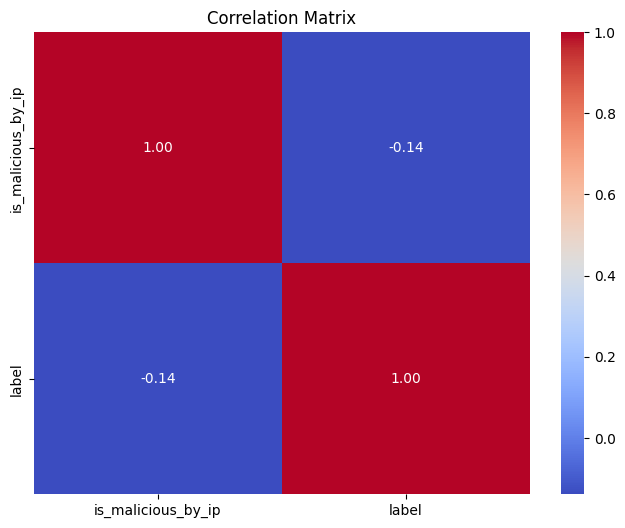

In [12]:

# 'is_malicious' 컬럼 추가: IP 주소가 포함되지 않은 경우를 악성 URL로 판단
df['is_malicious_by_ip'] = df['url'].apply(lambda x: not contains_ip(x))  # True = 악성 URL, False = 정상 URL


# 상관계수 계산
correlation_matrix = df[[ 'is_malicious_by_ip', 'label']].corr()

# 히트맵 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()